In [1]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 617.3 kB/s eta 0:00:00


In [52]:
"""
Created on Tue Jan 17 13:24:23 2023

@author: DIMITRIS

Description: Conditional GAN Network, for eaducational purposed
Status: Working, needs some fine-tuning
"""


# %% Import and stuff
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import linalg
import lpips


NUM_EPOCHS = 150
LR = 0.0002
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999


GEN_STATE_DICT = "gen_state_dict"
DISC_STATE_DICT = "disc_state_dict"
GEN_OPTIMIZER = "gen_optimizer"
DISC_OPTIMIZER = "disc_optimizer"
G_LOSSES = "g_losses"
D_LOSSES = "d_losses"



SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
#small batch size cause inception_v3 hogs ram
BATCH_SIZE = 32

specific_latent = torch.tensor([[0.7628, 0.1779, 0.3978, 0.3606, 0.6387,
         0.3044, 0.8340, 0.3884, 0.9313, 0.5635, 0.1994, 0.6934, 0.5326,
         0.3676, 0.5342, 0.9480, 0.4120, 0.5845, 0.4035, 0.5298, 0.0177,
         0.5605, 0.6453, 0.9576, 0.7153, 0.1923, 0.8122, 0.0937, 0.5744,
         0.5951, 0.8890, 0.4838, 0.5707, 0.6760, 0.3738, 0.2796, 0.1549,
         0.8220, 0.2800, 0.4051, 0.2553, 0.1831, 0.0046, 0.9021, 0.0264,
         0.2327, 0.8261, 0.0534, 0.1582, 0.4087, 0.9047, 0.1409, 0.6864,
         0.1439, 0.3432, 0.1072, 0.5907, 0.6756, 0.6942, 0.6814, 0.3368,
         0.4138, 0.8030, 0.7024, 0.3309, 0.7288, 0.2193, 0.1954, 0.9948,
         0.1201, 0.9483, 0.7407, 0.4849, 0.6500, 0.8649, 0.7405, 0.4725,
         0.5373, 0.6541, 0.5444, 0.7425, 0.8940, 0.3580, 0.3905, 0.8924,
         0.2995, 0.3726, 0.5399, 0.3057, 0.3380, 0.8313, 0.1137, 0.0120,
         0.7714, 0.2561, 0.2569, 0.2994, 0.7648, 0.2413, 0.6101
        ]])


img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))

Device:cuda


In [53]:
# %% helper funcitons


def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    generator.load_state_dict(checkpoint[GEN_STATE_DICT])
    optimizer_G.load_state_dict(checkpoint[GEN_OPTIMIZER])
    discriminator.load_state_dict(checkpoint[DISC_STATE_DICT])
    optimizer_D.load_state_dict(checkpoint[DISC_OPTIMIZER])
    G_losses = checkpoint.get(G_LOSSES, 0)
    D_losses = checkpoint.get(D_LOSSES, 0)
    


# takes input tensor and return a tensor of same size but every element has different value
def build_fake_labels(old_list):
  
    new_list = []

    for i, x in enumerate(old_list):

        if (i % 10) != x:
            new_list.append(i % 10)
        else:
            new_list.append((x.item()+1) % 10)

    return torch.tensor(new_list, dtype=torch.int64).to(device)


def add_noise(inputs, variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise

def gen_image(caption=-1,randomLatent=True):
    generator.to('cpu')
    discriminator.to('cpu')

    with torch.no_grad():
        for image,_ in train_loader:
            f, axarr = plt.subplots(1)
            
            if randomLatent:
                latent = torch.rand_like(torch.Tensor(1,100))
            else:
                latent = specific_latent
                
            if caption == -1:
                caption = random.randint(0, 9)
            
            caption = torch.tensor(caption, dtype=torch.int64)
            fake_image = generator(latent,caption)  
           
            
            #axarr.imshow(add_noise(image[0][0],0.5))    
            axarr.imshow(fake_image[0][0])   
            print("Supposed to be %d" %caption.item())
    
            break
        
def discriminate_image(caption=-1,genOrReal=0):#random.randint(0, 1)):
    generator.to('cpu')
    discriminator.to('cpu')
    
    with torch.no_grad():
        for  i, (imgs, labels) in enumerate(example_loader):
            f, axarr = plt.subplots(1)
            
            fake_labels = build_fake_labels(labels.to(device))
            labels = labels.to('cpu')
            z = Variable(Tensor(np.random.normal(0, 1, (1,LATENT_DIM)))).cpu()
            if caption == -1:
                caption = random.randint(0, 9)
            caption = torch.tensor(caption, dtype=torch.int64)
            
            
            #feed discriminator fake image, expect "0" output
            if genOrReal == 0:
                fake_image = generator(z,caption)
                axarr.imshow(fake_image[0].reshape(-1, 28, 28)[0])
                pred = discriminator(fake_image,caption).detach()
                print("Discriminator Prediction: {},Should be: {}, label = {}".format(pred,"0",caption))
            #feed discriminator real image, expect "1" output
            else:
                fake_image = generator(z,labels[0])
                axarr.imshow(imgs[0].reshape(-1, 28, 28)[0])
                pred = discriminator(imgs.detach(),labels[0].detach()).detach()
                print("Discriminator Prediction: {},Should be: {}, label= {}".format(pred,"1",labels[0]+1))
            
    
            break        

# Check if a tensor image is normalized in [-1,1]
# returns true if it s within [-1,1]
def is_normalized(image):
  
  tensor_image_normalized = image[0]  # your tensor image here

  min_value = tensor_image_normalized.min().item()
  max_value = tensor_image_normalized.max().item()

  
  return (min_value >= -1.0 and max_value <= 1.0)


def colorize(image):
  return torch.cat([image, image, image], dim=1)




In [54]:
# %%train data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)


train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False
                                )

test_loader = data.DataLoader(
                                train_dataset,
                                batch_size=60000,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                )



In [55]:
# %% Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

        self.emb = nn.Embedding(10, 50)
        self.emb_fc = nn.Linear(50, 784)

        self.nconv1 = nn.Conv2d(2, 64, kernel_size=5)
        self.nconv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.nfc1 = nn.Linear(1152, 164)
        self.nfc2 = nn.Linear(164, 1)

    # oldWay flag to select between 2 train methods, not sure which is best yet
    def forward(self, x, c, oldWay=False):

        c = self.emb(c)
        c = self.emb_fc(c)
        c = c.view(-1, 1, 28, 28)
        x = torch.cat((c, x), 1)  # concat image[1,28,28] with text [1,28,28]

        x = F.leaky_relu(self.nconv1(x))
        x = F.leaky_relu(self.nconv2(x))
        x = self.pool(x)
        x = self.pool2(x)
        x = x.view(-1, 1152)
        x = F.leaky_relu(self.nfc1(x))
        x = F.dropout(x, training=self.training)
        x = self.nfc2(x)

        x = torch.sigmoid(x)
        return x


# %% Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(LATENT_DIM, 7*7*63)  # [n,100]->[n,3087]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16] [32,..,..]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 32, , ]->[n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 16, 34, 34]-> [n, 1, 28, 28]
        
        self.emb = nn.Embedding(10, 50) 
        self.label_lin = nn.Linear(50, 49)
        self.conv_x_c = nn.ConvTranspose2d(65, 64, 4, stride=2)  # upsample [65,7,7] -> [64,14,14]
        self.tanh = nn.Tanh()

    def forward(self, x, c):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)  # (n,100) -> (n,3187)
        x = F.leaky_relu(x)
        x = x.view(-1, 63, 7, 7)  # (n,3187) -> (63,7,7)
        
        #Encode label
        c = self.emb(c)  # (n,) -> (n,50)
        c = self.label_lin(c)  # (n,50) -> (n,49)
        c = c.view(-1, 1, 7, 7)  # (n,49) -> (n,1,7,7)
        x = torch.cat((c, x), 1) # concat image[63,7,7] with text [1,7,7]

        x = self.ct1(x)  # [n, 64, 16, 16] [32,34,34]
        x = F.leaky_relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.leaky_relu(x)

        # Convolution to 28x28 (1 feature map)
        x = self.tanh(self.conv(x))
        return x
    

In [56]:
#%% Loss fucntion, optimizers
loss_func = nn.BCELoss()
d_loss_func = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR,betas=(B1 ,B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR,betas=(B1 ,B2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   


In [57]:
#if you're running this on colab, download corresponding chackpoint file and upload it to runtime
load_checkpoint(torch.load("cond_gan_pytorch_good.pth.tar",map_location=(device)))


Supposed to be 3


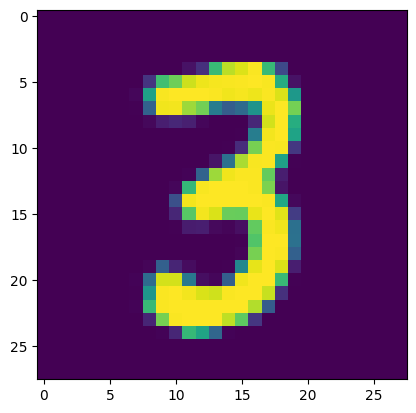

In [59]:
#Test image generation
gen_image()

In [70]:

fake_images = []
real_images = []
with torch.no_grad():
    generator.to('cpu')
    discriminator.to('cpu')

    for i, (imgs,label) in enumerate(train_loader):
        real_images = imgs
        
        #caption = random.randint(0, 9)   
        #caption = torch.tensor(caption, dtype=torch.int64)
        #latent = torch.rand_like(torch.Tensor(1,100))
        #fake_images = generator(latent,caption)
        
        
        for i in range(BATCH_SIZE):
          caption = label[i]
          latent = torch.rand_like(torch.Tensor(1,100))
          fake_image = generator(latent,caption)

          if (i==0):
            print('one')
            fake_images = generator(latent,caption)
          else:
            fake_images = torch.cat((fake_images, fake_image), 0)
        break
    
    #fake_images = fake_images[:BATCH_SIZE,:,:,:]
    #real_images = real_images[:BATCH_SIZE,:,:,:]

one


In [ ]:
#%% Inception score
from torchvision.models import inception_v3
from scipy.stats import entropy

with torch.no_grad():
    images = fake_images
    batch_size = BATCH_SIZE
    resize=True
    
    # Load pre-trained Inception-v3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    model.requires_grad_ = False

    
    # Prepare the images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if resize:
        images = torch.cat([images,images,images],dim=1)
        images = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(num_output_channels=3),
        ])(images)
    else:
        images = [torch.from_numpy(image.transpose(2, 0, 1)).float().div(255).unsqueeze(0) for image in images]
    
    # Compute the predictions
    n_images = images.shape[0]
    n_batches = int(np.ceil(n_images / batch_size))
    preds = []
    with torch.no_grad():
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_images)
            batch = images.to(device)
            #batch = torch.cat(images[start_idx:end_idx], dim=0).to(device)
            pred = model(batch.detach())
            pred = F.softmax(pred, dim=1).cpu().numpy()
            preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    
    # Compute the Inception Score
    scores = []
    for i in range(preds.shape[0]):
        p_yx = preds[i]
        p_y = np.expand_dims(np.mean(p_yx, axis=0), axis=0)
        scores.append(entropy(p_yx.T, p_y.T))
    kl_divergence = np.mean(scores)
    entropy_y = entropy(np.mean(preds, axis=0))
    inception_score = np.exp(kl_divergence - entropy_y)
    print(f'Inception score: {inception_score:.2f}')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (reco

Inception score: 0.43


In [ ]:
#FID score

f_images = torch.cat([fake_images, fake_images, fake_images], dim=1)
f_images = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
])(f_images)


# load a pre-trained Inception-v3 model
inception_model = inception_v3(pretrained=True, aux_logits=True,)
inception_model.to(device)
inception_model.eval()

# compute the feature representations of the real and fake images
real_features = []
fake_features = []
for batch in train_loader:
    images, _ = batch
    images = images.to(device)
    with torch.no_grad():
        images = torch.cat([images,images,images],dim=1)
        images = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(num_output_channels=3),
        ])(images)

           
        features = inception_model(images).view(images.size(0), -1)
    real_features.append(features.cpu().numpy())
    break
with torch.no_grad():
    features = inception_model(f_images).view(f_images.size(0), -1)
fake_features.append(features.cpu().numpy())

# calculate the mean and covariance of the feature representations
real_features = np.concatenate(real_features, axis=0)
fake_features = np.concatenate(fake_features, axis=0)
mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

# calculate the FID score
mu_diff = mu1 - mu2
sigma_diff_sqrt = linalg.sqrtm(sigma1 @ sigma2)
fid_score = np.real(np.trace(sigma1 + sigma2 - 2*sigma_diff_sqrt)) + np.dot(mu_diff, mu_diff)
print(f'FID score: {fid_score:.2f}')


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py

FID score: 338.79


In [ ]:
#LPIPS metric 
loss_fn_alex = lpips.LPIPS(net='alex') 

lpip_fake = colorize(fake_images)
lpip_real = colorize(real_images) # !! images must be rbg and within [-1,1]

lpip_fake = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_fake)

lpip_real = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_real)



d = loss_fn_alex(lpip_fake, lpip_real)
print("LPIPS? ",d[0].item())



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS?  0.1901334673166275


In [ ]:
import torch

# create a tensor
my_tensor = d

# get minimum value
min_val = torch.min(my_tensor)

# get maximum value
max_val = torch.max(my_tensor)

# get mean value
mean_val = torch.mean(my_tensor)

# print the results
print("Minimum value:", min_val.item())
print("Maximum value:", max_val.item())
print("Mean value:", mean_val.item())


Minimum value: 0.07334506511688232
Maximum value: 0.30068492889404297
Mean value: 0.16741244494915009


In [ ]:
import torch
import torch.nn as nn

# create two tensors
y_true = real_images
y_pred = fake_images

# create a criterion for calculating MSE
criterion = nn.MSELoss()

# calculate MSE
mse = criterion(y_pred, y_true)

# print the result
print("MSE:", mse.item())


MSE: 0.3464761972427368


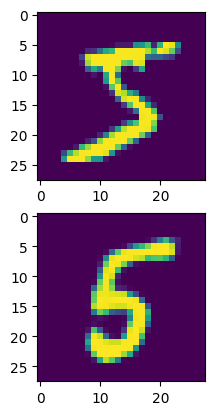

In [71]:
ex1 = real_images[:32]
ex2 = fake_images[:32]

f, axarr = plt.subplots(2)
axarr[0].imshow(ex1[0][0])
axarr[1].imshow(ex2[0][0])   


In [61]:
#Calculate mean of images(takes ~3 mins for max=1000)
mnist_means = []
number_mean = []
max = 1000

#for each number(0,9)
for num in range(10):

  #for each image in dataset
  for k,(images,labels) in enumerate(test_loader):  
    for i in range(len(labels[:])):
    
      #if it's the number we want
      if num == labels[i].item():
        number_mean.append(images[i])
        
        if len(number_mean) >= max:
          break
  number_mean = torch.stack(number_mean,dim=0)
  number_mean = torch.mean(number_mean, dim=0)


  mnist_means.append(number_mean)
  number_mean = []
  
mnist_mean = torch.stack(mnist_means,dim=0)

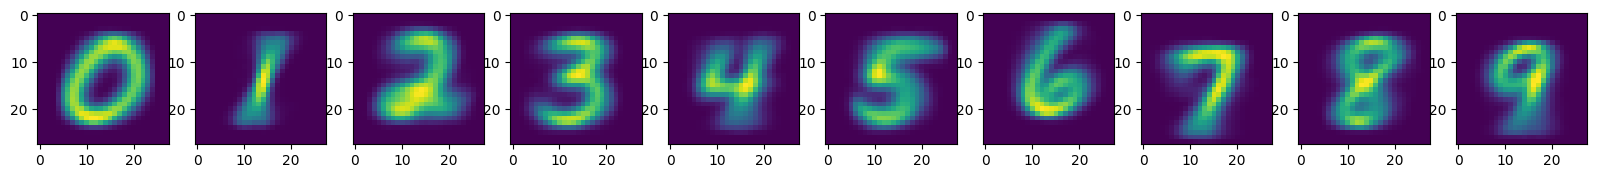

In [62]:
 fig, axes = plt.subplots(nrows=1,ncols=10,figsize=(20,2.5))
 for i in range(len(mnist_mean[:])):
  axes[i].imshow(mnist_mean[i][0])

Define the distance as the minimum of the mean Euclidean distance of x
to each mean $\bar{x}k$ :
 
 $$d=\min _{0 \leq k \leq 9} \frac{1}{W H} \sqrt{\sum_i^W \sum_j^H\left(x_{i j}-\bar{x}_{k, i j}\right)^2}$$

The score is the average of $d$ over all samples.


In [88]:
#Calculate average distances

#On how many generated images to average on
num_samples = 1000
fake_images_means = []
fake_image_mean = []

distances = []
with torch.no_grad():
  for num in range(10):
    for i in range(num_samples):
      latent = torch.rand_like(torch.Tensor(1,100))
      caption = torch.tensor(num, dtype=torch.int64)
      
      fake_image = generator(latent,caption)  
      fake_image_mean.append(fake_image[0])
    
    fake_image_mean = torch.stack(fake_image_mean,dim=0)
    fake_image_mean = torch.mean(fake_image_mean, dim=0)

    fake_images_means.append(fake_image_mean)
    fake_image_mean = []  

  

In [89]:
fake_images_means2 = torch.stack(fake_images_means,dim=0)

In [90]:
fake_images_means2.shape

torch.Size([10, 1, 28, 28])

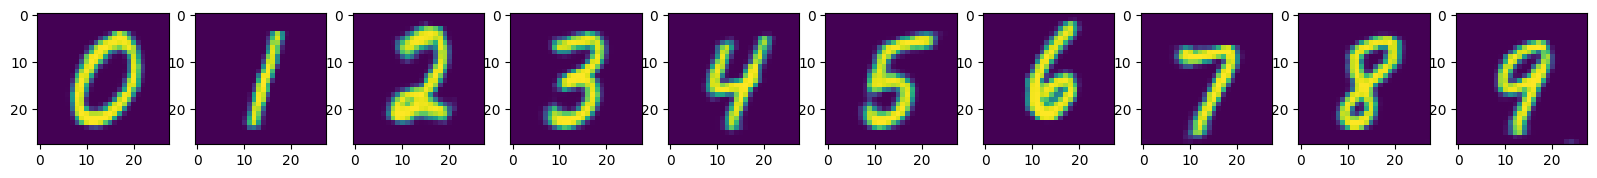

In [91]:
fig, axes = plt.subplots(nrows=1,ncols=10,figsize=(20,2.5))
for i in range(len(fake_images_means2[:])):
  axes[i].imshow(fake_images_means2[i][0])

In [93]:
distances = []
for i in range(len(fake_images_means2[:])):

  distance = torch.norm(mnist_means[i] - fake_images_means2[i], p=2)
  distances.append(distance.item())
# Print the distance
print('Euclidean distance:', distances)

Euclidean distance: [9.807600975036621, 6.3585896492004395, 10.660109519958496, 9.003460884094238, 8.770489692687988, 10.636665344238281, 9.809232711791992, 7.376132965087891, 9.426525115966797, 8.590899467468262]


In [72]:
#Calculate average distances

#On how many generated images to average on
num_samples = 100
fake_images_means = []
fake_image_mean = []

distances = []
with torch.no_grad():
  for num in range(1):
    for i in range(num_samples):
      latent = torch.rand_like(torch.Tensor(1,100))
      caption = torch.tensor(num, dtype=torch.int64)
      
      #generate fake image and calculate distance to mean
      fake_image = generator(latent,caption)  
      distance = torch.norm(mnist_mean[num] - fake_image[0], p=2)
      distances.append(distance.item())
      

#distances = torch.stack(distances,dim=0)


11.216726999282837
